# Well Count Graphs

This notebook should help inform where wells are in the state and their proximity to streams

In [2]:
# Packages and paths
# %%
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import geopandas as gp
import scipy.stats as sp
import sys
import seaborn as sns
import math
import dask.dataframe as dd
import dask_geopandas as dgp
import gc
import time

# Add the path to the Utils folder
utils_path = os.path.abspath(os.path.join('..', 'Utils'))
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Now you can import the functions from CustomFunctions.py
import CustomFunctions as cf

# Local paths
datapath = '../../Data'
inputpath = '../../Data/Input'
outputpath = '../../Data/Output/Local'
shapepath = inputpath+'/Shapefiles'
figurepath = '../../Figures/Local/'




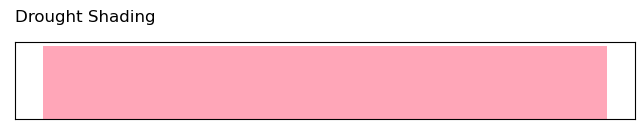

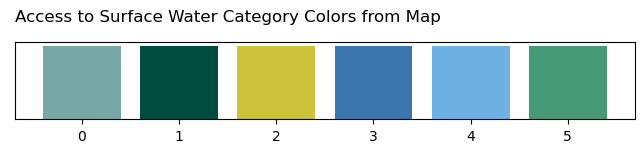

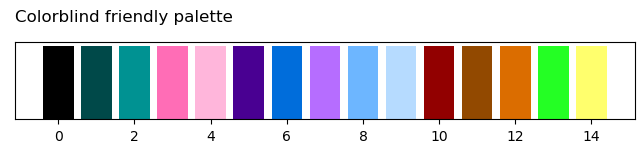

In [3]:
# %% Creating colors
drought_color = '#ffa6b8'

# Color blind palette
# https://jacksonlab.agronomy.wisc.edu/2016/05/23/15-level-colorblind-friendly-palette/
cblind =["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

# Colors from map
cap = '#77A8A5' #'#C6652B'
cap_secondary = '#004D40'
# noCAP = '#EDE461' # This is one from the map in the trend paper
noCAP = '#CCC339' # This color but darker for lines
GWdom = '#3B76AF'
mixed = '#6EB2E4'
swdom = '#469B76'
a2sw_colors =[cap,cap_secondary,noCAP,GWdom,mixed,swdom]

# Create a bar plot to visualize colors
palette = [drought_color]
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Drought Shading',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
ax.set_xticks([])
plt.show()

palette = a2sw_colors
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Access to Surface Water Category Colors from Map',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
plt.show()

palette = cblind
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Colorblind friendly palette',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
plt.show()

In [4]:
filename = "HUC4sShallowGWWellCountSummary.csv"
filepath = os.path.join(outputpath, filename)
boundaries_stats = pd.read_csv(filepath)
boundaries_stats = boundaries_stats.rename(columns={"huc4_wb":"huc4"})
boundaries_stats = boundaries_stats.drop(['Unnamed: 0'], axis=1)
boundaries_stats

,Decade,huc4,DTW_Category,Well Count
0,1980,1501,Deep (10-61m),108
1,1980,1501,Near Surface (<2m),116
2,1980,1501,Shallow (5-10m),37
3,1980,1501,Very Shallow (2-5m),29
4,1980,1502,Deep (10-61m),403
...,...,...,...,...
155,2020,1507,Very Shallow (2-5m),48
156,2020,1508,Deep (10-61m),42
157,2020,1508,Near Surface (<2m),4
158,2020,1508,Shallow (5-10m),13


In [5]:
filename = "HUC4sMeltedDataframe.csv"
filepath = os.path.join(outputpath, filename)
boundaries_melted = pd.read_csv(filepath)
# boundaries_melted = boundaries_melted.rename(columns={"huc4_wb":"huc4"})
# boundaries_melted = boundaries_melted.drop(['Unnamed: 0'], axis=1)
boundaries_melted

,Unnamed: 0,Combo_ID,huc4_wb,Date,DTW,DTW_meters,DTW_Category,Decade
0,214,85466,1501,1980-01-01,100.00,30.480000,Deep (10-61m),1980
1,8462,352135113423001,1501,1980-01-01,76.20,23.225760,Deep (10-61m),1980
2,8465,352217113395801,1501,1980-01-01,21.80,6.644640,Shallow (5-10m),1980
3,8474,352358113390401,1501,1980-01-01,27.20,8.290560,Shallow (5-10m),1980
4,38438,603408,1501,1980-01-01,30.00,9.144000,Shallow (5-10m),1980
...,...,...,...,...,...,...,...,...
71832,34666148,619562,1508,2023-11-01,61.60,18.775680,Deep (10-61m),2020
71833,34679097,808998,1508,2023-11-01,58.80,17.922240,Deep (10-61m),2020
71834,34679098,809844,1508,2023-11-01,94.30,28.742640,Deep (10-61m),2020
71835,34752696,203421,1508,2024-01-01,10.13,3.087624,Very Shallow (2-5m),2020


In [13]:
individualwells = pd.pivot_table(boundaries_melted, index=["Combo_ID"], columns=["Decade"], values=["DTW_meters"], dropna=False, aggfunc=np.median)
individualwells

DTW_meters                                    
Decade                1980       1990     2000     2010   2020
Combo_ID                                                      
83578               3.6576        NaN      NaN      NaN    NaN
84067               0.0000        NaN      NaN      NaN    NaN
84614               3.6576        NaN      NaN      NaN    NaN
84630               5.4864        NaN      NaN      NaN    NaN
84633               5.4864        NaN      NaN      NaN    NaN
...                    ...        ...      ...      ...    ...
363620113565501     2.5908   2.865120  2.86512  2.22504  3.048
364710114033401        NaN  45.201840      NaN      NaN    NaN
364825114052801        NaN  11.612880      NaN      NaN    NaN
365429113555301        NaN  19.242024      NaN      NaN    NaN
365432113560501        NaN  17.526000      NaN      NaN    NaN

[43783 rows x 5 columns]

In [14]:
individualwells.reset_index(inplace=True)

In [16]:
individualwells.to_csv(outputpath+"/MedianWL_Decades_IndividualWells.csv")

In [15]:
individualwells

Combo_ID DTW_meters                                    
Decade                        1980       1990     2000     2010   2020
0                 83578     3.6576        NaN      NaN      NaN    NaN
1                 84067     0.0000        NaN      NaN      NaN    NaN
2                 84614     3.6576        NaN      NaN      NaN    NaN
3                 84630     5.4864        NaN      NaN      NaN    NaN
4                 84633     5.4864        NaN      NaN      NaN    NaN
...                 ...        ...        ...      ...      ...    ...
43778   363620113565501     2.5908   2.865120  2.86512  2.22504  3.048
43779   364710114033401        NaN  45.201840      NaN      NaN    NaN
43780   364825114052801        NaN  11.612880      NaN      NaN    NaN
43781   365429113555301        NaN  19.242024      NaN      NaN    NaN
43782   365432113560501        NaN  17.526000      NaN      NaN    NaN

[43783 rows x 6 columns]

In [38]:
boundaries_stats.columns

Index(['Decade', 'huc4', 'DTW_Category', 'Well Count'], dtype='object')

In [39]:
distances = [100, 
             500, 
             1000, 
             1500, 
             2000
             ]

stats_distances = {}

for i in distances:
    filename = f"HUC4s_{i}_ShallowGWWellCountSummary.csv"
    filepath = os.path.join(outputpath, filename)
    stats_distances[f"{i}m"] = pd.read_csv(filepath)
    stats_distances[f"{i}m"] = stats_distances[f"{i}m"].drop(['Unnamed: 0'], axis=1)

In [40]:
stats_distances["100m"]

,Decade,huc4,DTW_Category,Well Count
0,1980,1501,Deep (10-61m),5
1,1980,1501,Near Surface (<2m),5
2,1980,1501,Shallow (5-10m),3
3,1980,1501,Very Shallow (2-5m),6
4,1980,1502,Deep (10-61m),38
...,...,...,...,...
152,2020,1507,Shallow (5-10m),9
153,2020,1507,Very Shallow (2-5m),2
154,2020,1508,Near Surface (<2m),3
155,2020,1508,Shallow (5-10m),8


In [41]:
# Merge all distance dataframes into boundaries_stats
for key, df in stats_distances.items():
    boundaries_stats = boundaries_stats.merge(df, on=["Decade", "huc4", "DTW_Category"], how="left", suffixes=("", f"_{key}"))

# Display the final merged dataframe
boundaries_stats.head()

,Decade,huc4,DTW_Category,Well Count,Well Count_100m,Well Count_500m,Well Count_1000m,Well Count_1500m,Well Count_2000m
0,1980,1501,Deep (10-61m),108,5.0,21,44,61,65
1,1980,1501,Near Surface (<2m),116,5.0,25,42,55,72
2,1980,1501,Shallow (5-10m),37,3.0,20,24,24,26
3,1980,1501,Very Shallow (2-5m),29,6.0,19,21,21,21
4,1980,1502,Deep (10-61m),403,38.0,152,254,301,337


In [61]:
# Identify the reference column (first distance)
reference_column = "Well Count"  # Change this if your first column is different

boundaries_percents = boundaries_stats.copy()

# Create new columns with normalized values
for dist in distances:
    column_name = f"Well Count_{dist}m"
    if column_name in boundaries_stats.columns and reference_column in boundaries_stats.columns:
        boundaries_percents[f"Ratio_{dist}m"] = boundaries_stats[column_name] / boundaries_stats[reference_column]

# Display the first few rows to verify
boundaries_percents.head()


,Decade,huc4,DTW_Category,Well Count,Well Count_100m,Well Count_500m,Well Count_1000m,Well Count_1500m,Well Count_2000m,Ratio_100m,Ratio_500m,Ratio_1000m,Ratio_1500m,Ratio_2000m
0,1980,1501,Deep (10-61m),108,5.0,21,44,61,65,0.046296,0.194444,0.407407,0.564815,0.601852
1,1980,1501,Near Surface (<2m),116,5.0,25,42,55,72,0.043103,0.215517,0.362069,0.474138,0.620690
2,1980,1501,Shallow (5-10m),37,3.0,20,24,24,26,0.081081,0.540541,0.648649,0.648649,0.702703
3,1980,1501,Very Shallow (2-5m),29,6.0,19,21,21,21,0.206897,0.655172,0.724138,0.724138,0.724138
4,1980,1502,Deep (10-61m),403,38.0,152,254,301,337,0.094293,0.377171,0.630273,0.746898,0.836228


In [43]:
boundaries_percents.columns

Index(['Decade', 'huc4', 'DTW_Category', 'Well Count', 'Well Count_100m',
       'Well Count_500m', 'Well Count_1000m', 'Well Count_1500m',
       'Well Count_2000m', 'Ratio_100m', 'Ratio_500m', 'Ratio_1000m',
       'Ratio_1500m', 'Ratio_2000m'],
      dtype='object')

In [52]:
boundaries_percents = boundaries_percents.drop(columns = [
       # 'Well Count', 
       'Well Count_100m',
       'Well Count_500m', 'Well Count_1000m', 'Well Count_1500m',
       'Well Count_2000m'])
boundaries_percents

,Decade,huc4,DTW_Category,Well Count,Ratio_100m,Ratio_500m,Ratio_1000m,Ratio_1500m,Ratio_2000m
0,1980,1501,Deep (10-61m),108,0.046296,0.194444,0.407407,0.564815,0.601852
1,1980,1501,Near Surface (<2m),116,0.043103,0.215517,0.362069,0.474138,0.620690
2,1980,1501,Shallow (5-10m),37,0.081081,0.540541,0.648649,0.648649,0.702703
3,1980,1501,Very Shallow (2-5m),29,0.206897,0.655172,0.724138,0.724138,0.724138
4,1980,1502,Deep (10-61m),403,0.094293,0.377171,0.630273,0.746898,0.836228
...,...,...,...,...,...,...,...,...,...
155,2020,1507,Very Shallow (2-5m),48,0.041667,0.187500,0.291667,0.645833,0.791667
156,2020,1508,Deep (10-61m),42,NaN,0.261905,0.309524,0.547619,0.714286
157,2020,1508,Near Surface (<2m),4,0.750000,1.000000,1.000000,1.000000,1.000000
158,2020,1508,Shallow (5-10m),13,0.615385,0.846154,0.846154,1.000000,1.000000


In [62]:
boundaries_percents.to_csv(outputpath+"wellcounts_stats_distancetostreams.csv")

In [53]:
category_order = ['Near Surface (<2m)', 'Very Shallow (2-5m)', 'Shallow (5-10m)', 'Deep (10-61m)']


In [54]:
# Define colors
colors = {
    'Near Surface (<2m)': cblind[5],
    'Very Shallow (2-5m)': cblind[6],
    'Shallow (5-10m)': cblind[8],
    'Deep (10-61m)': cblind[9]
}

In [ ]:

df = boundaries_percents
listofhucs = df["huc4"].unique().tolist()
num_hucs = len(listofhucs)

# Determine grid size
cols = math.ceil(math.sqrt(num_hucs))  # Try to make a roughly square grid
rows = math.ceil(num_hucs / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6), constrained_layout=True)

# Flatten axes if there's more than one row
if rows > 1 or cols > 1:
    axes = axes.flatten()
else:
    axes = [axes]  # Ensure it's iterable

for i, bitch in enumerate(listofhucs):
    subset = df[df["huc4"] == bitch]
    summary_df_huc = subset.groupby(['Decade', 'DTW_Category'])
    summary_df_huc.rename(columns={'Combo_ID': 'Well Count'}, inplace=True)
    summary_pivot = summary_df_huc.pivot(index='Decade', columns='DTW_Category', values='Well Count').fillna(0)
    summary_pivot = summary_pivot[category_order]
    fig, ax = plt.subplots(figsize=(10, 6))
    summary_pivot.plot(kind='bar', stacked=True, color=[colors[c] for c in summary_pivot.columns], ax=ax)
    ax.set_title(f'Distribution of Wells Over Time [HUC {bitch}]')
    ax.set_xlabel('Time Period (Decade)')
    ax.set_ylabel('Number of Well Measurements')
    ax.tick_params(axis='x', rotation=0)
    # axes[i].set_ylim(65, -5)

In [ ]:
boundaries_stats

In [55]:
# Summing all HUCs together by Decade and DTW_Category
# summary_table = boundaries_stats.groupby(["Decade", "DTW_Category"]).sum().reset_index()
summary_table = boundaries_percents.groupby(["Decade", "DTW_Category"]).sum().reset_index()

# Display the summary table
summary_table.head()


,Decade,DTW_Category,huc4,Well Count,Ratio_100m,Ratio_500m,Ratio_1000m,Ratio_1500m,Ratio_2000m
0,1980,Deep (10-61m),12036,6509,0.725762,2.838580,4.475308,5.444412,6.156637
1,1980,Near Surface (<2m),12036,1740,1.378241,3.190102,4.227762,5.135828,5.802424
2,1980,Shallow (5-10m),12036,2665,1.542041,4.893236,6.117222,6.681753,7.003854
3,1980,Very Shallow (2-5m),12036,1944,2.119696,4.859899,5.816444,6.254063,6.619466
4,1990,Deep (10-61m),12036,10048,0.587103,2.412079,3.858132,4.761200,5.322168


In [ ]:
# Summing all HUCs together by Decade and DTW_Category
# summary_table = boundaries_stats.groupby(["Decade", "DTW_Category"]).sum().reset_index()
summary_table_nocategories = boundaries_percents.groupby(["Decade", "DTW_Category"]).sum().reset_index()

# Display the summary table
summary_table.head()


,Decade,DTW_Category,huc4,Well Count,Ratio_100m,Ratio_500m,Ratio_1000m,Ratio_1500m,Ratio_2000m
0,1980,Deep (10-61m),12036,6509,0.725762,2.838580,4.475308,5.444412,6.156637
1,1980,Near Surface (<2m),12036,1740,1.378241,3.190102,4.227762,5.135828,5.802424
2,1980,Shallow (5-10m),12036,2665,1.542041,4.893236,6.117222,6.681753,7.003854
3,1980,Very Shallow (2-5m),12036,1944,2.119696,4.859899,5.816444,6.254063,6.619466
4,1990,Deep (10-61m),12036,10048,0.587103,2.412079,3.858132,4.761200,5.322168


In [56]:
summary_pivot

DTW_Category,Near Surface (<2m),Very Shallow (2-5m),Shallow (5-10m),Deep (10-61m)
Decade,,,,
1980,665,1003,1643,2604
1990,735,1154,1650,2986
2000,171,811,1217,2462
2010,122,280,485,995
2020,36,143,236,476


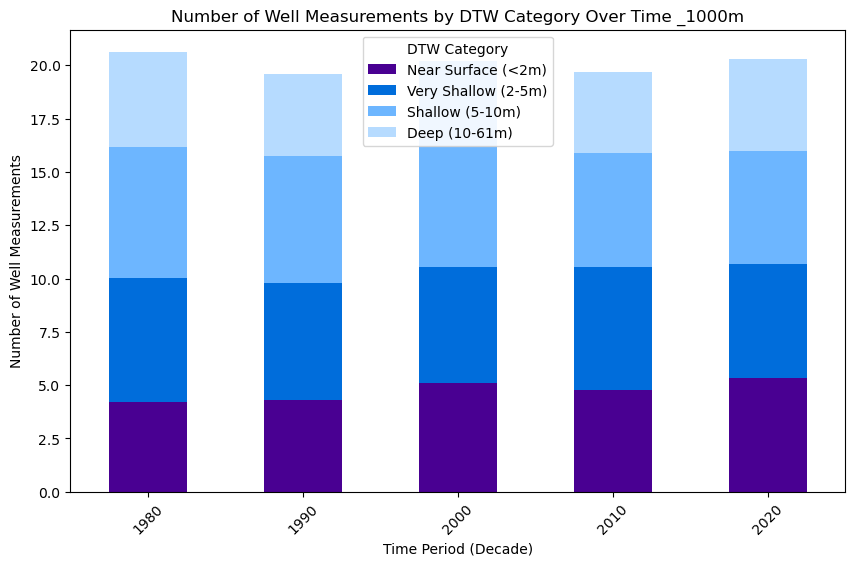

In [59]:
dist_plotting = "_1000m"

# Pivot the data to get each DTW category as a separate column for stacking
# summary_pivot = summary_table.pivot(index='Decade', columns='DTW_Category', values=f'Well Count{dist_plotting}').fillna(0)
summary_pivot = summary_table.pivot(index='Decade', columns='DTW_Category', values=f'Ratio{dist_plotting}').fillna(0)

# Define the desired order for DTW categories
category_order = ['Near Surface (<2m)', 'Very Shallow (2-5m)', 'Shallow (5-10m)', 'Deep (10-61m)']

# Reorder the columns in summary_pivot
summary_pivot = summary_pivot[category_order]

# Define colors
colors = {
    'Near Surface (<2m)': cblind[5],
    'Very Shallow (2-5m)': cblind[6],
    'Shallow (5-10m)': cblind[8],
    'Deep (10-61m)': cblind[9]
}

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
summary_pivot.plot(kind='bar', stacked=True, color=[colors[c] for c in summary_pivot.columns], ax=ax)

# Labels and title
plt.xlabel('Time Period (Decade)')
plt.ylabel('Number of Well Measurements')
plt.title(f'Number of Well Measurements by DTW Category Over Time {dist_plotting}')
plt.legend(title='DTW Category')
plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


In [63]:
print(colors)

{'Near Surface (<2m)': '#490092', 'Very Shallow (2-5m)': '#006ddb', 'Shallow (5-10m)': '#6db6ff', 'Deep (10-61m)': '#b6dbff'}


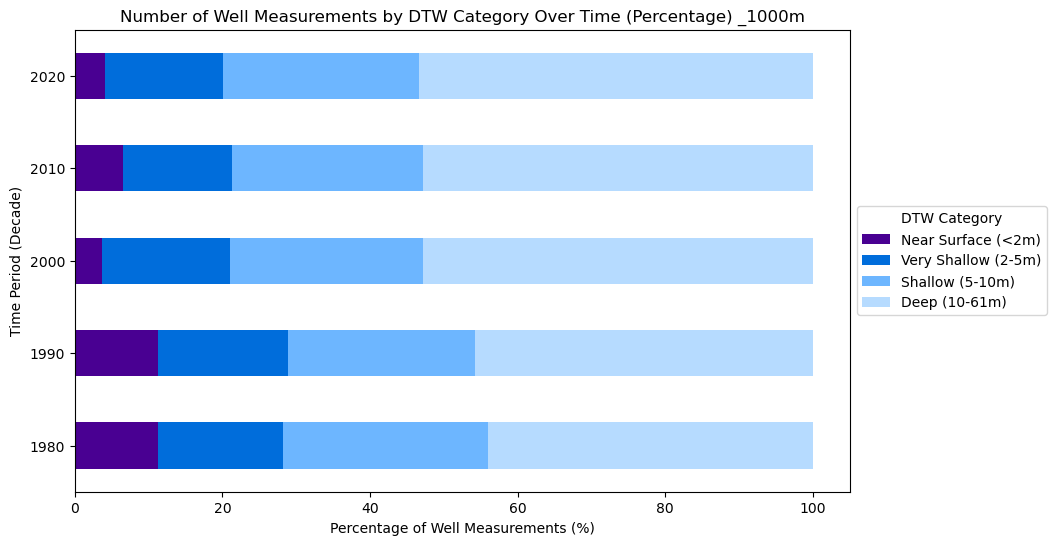

In [58]:
# Normalize data to get percentages
summary_pivot_percent = summary_pivot.div(summary_pivot.sum(axis=1), axis=0) * 100

# Plot stacked horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
summary_pivot_percent.plot(
    kind='barh',  # Horizontal bar chart
    stacked=True, 
    color=[colors[c] for c in summary_pivot.columns], 
    ax=ax
)

# Labels and title
plt.xlabel('Percentage of Well Measurements (%)')
plt.ylabel('Time Period (Decade)')
plt.title(f'Number of Well Measurements by DTW Category Over Time (Percentage) {dist_plotting}')
plt.legend(title='DTW Category', loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside for clarity
plt.xticks(rotation=0)  # Keep x-axis labels horizontal

plt.show()


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

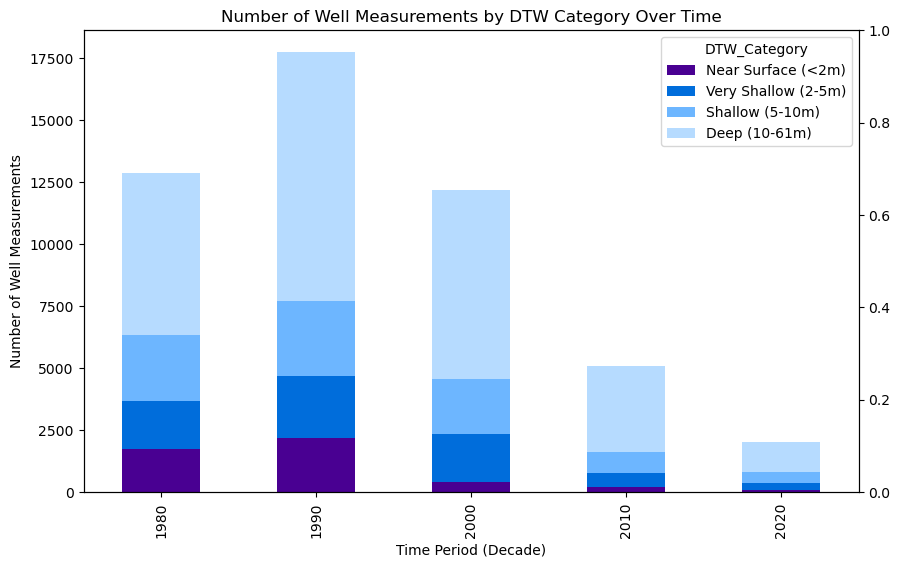

In [35]:
# Compute well counts per distance
distance_columns = [f"Well Count_{d}m" for d in distances]  # Adjust based on your column names
distance_sums = summary_table.groupby("Decade")[distance_columns].sum()

fig, ax1 = plt.subplots(figsize=(10, 6))

# Stacked bar plot
summary_pivot.plot(kind='bar', stacked=True, color=[colors[c] for c in summary_pivot.columns], ax=ax1)
ax1.set_xlabel("Time Period (Decade)")
ax1.set_ylabel("Number of Well Measurements")
ax1.set_title("Number of Well Measurements by DTW Category Over Time")

# Create a second y-axis for well counts per distance
ax2 = ax1.twinx()
for dist in distances:
    column_name = f"Well Count_{dist}m"
    ax2.plot(distance_sums.index, distance_sums[column_name], marker="o", label=f"{dist}m", linestyle="dashed")

ax2.set_ylabel("Total Well Counts by Distance")
ax2.legend(title="Buffer Distance", loc="upper left", bbox_to_anchor=(1, 1))

plt.xticks(rotation=45)
plt.show()


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

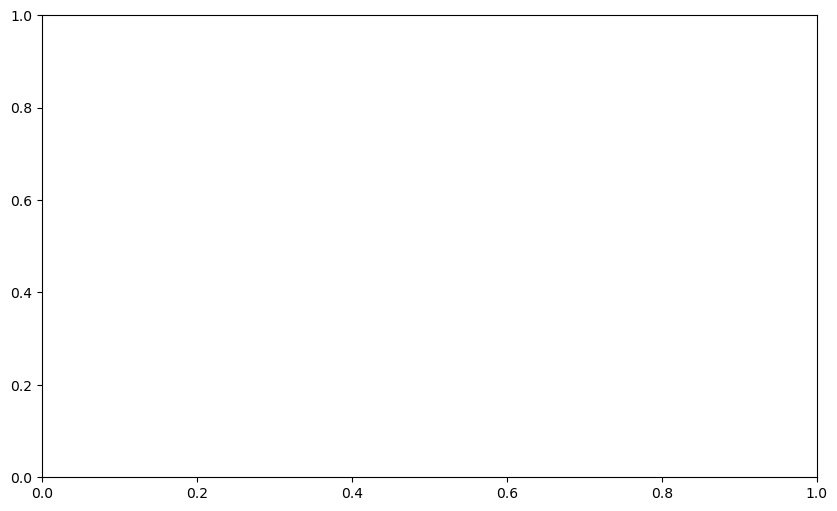

In [36]:
# Compute well counts per distance
distance_columns = [f"Well Count_{d}m" for d in distances]  # Adjust based on your column names
distance_sums = summary_table.groupby("Decade")[distance_columns].sum()

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each distance as a separate line
for dist in distances:
    column_name = f"Well Count_{dist}m"
    if column_name in distance_sums.columns:  # Ensure column exists
        ax.plot(distance_sums.index, distance_sums[column_name], marker="o", linestyle="-", label=f"{dist}m")

# Labels and title
ax.set_xlabel("Time Period (Decade)")
ax.set_ylabel("Number of Well Measurements")
ax.set_title("Well Measurements Over Time by Distance")
ax.legend(title="Buffer Distance")

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
